**Scenario: Job Application Screener**

Build an AI recruiter that evaluates applications step-by-step.

**Task:**

1. Extract candidate info from resume text (name, experience, skills)
2. Match skills against job requirements
3. Evaluate experience relevance (0-10 score)
4. Generate interview questions based on gaps
5. Write personalized rejection/invitation email
6. Create evaluation summary


In [87]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Optional, Dict, List
from pydantic import Field, BaseModel
from utils import AWSLLM

In [88]:
class CandidateInfo(BaseModel):
    name: str = Field(description="Full name")
    years_of_experience: int = Field(ge=0, description="Years of experience")
    skills: List[str] = Field(description="Technical skills")
    education: str
    email: Optional[str] = None

class SkillMatchScore(BaseModel):
    score: int = Field(ge=0, le=10)
    matched_skills: List[str]
    missing_skills: List[str]

In [89]:
class ScreenerState(TypedDict):
    resume_text: str
    requirements: str

    candidate_info: Optional[dict]
    skill_match_score: Optional[dict] 
    experience_score: int
    question: str
    email: str
    summary: str

In [90]:
llm = AWSLLM()

In [ ]:
# candidate info node
def candidate_info(state: ScreenerState)-> ScreenerState:
    resume_text = state['resume_text']
    
    prompt = f"""Extract the candidates name, years of experience, and list of skills from this resume text:
            {resume_text}
            Return JSON with keys: name, experience, skills, education, email."""
    
    candidate = llm.chat(
                    prompt=f"Extract candidate info from: {prompt}",
                    schema=CandidateInfo
                    )
    state['candidate_info'] = candidate

    return state
    
# skill node
def skill_score(state: ScreenerState)-> ScreenerState:
    candidate_info = state['candidate_info']
    job_requirements = state['requirements']

    prompt = f"""Compare candidate skills {candidate_info.skills} with job requirements {job_requirements}.
            Return skill_match_score (0-10) and missing_skills list."""

    skill_matching = llm.chat(
                    prompt=prompt,
                    schema=SkillMatchScore
                    )
    state['skill_match_score'] = skill_matching

    return state

# experience node 
def experience_score(state: ScreenerState)-> ScreenerState:
    candidate_info = state['candidate_info']
    job_requirements = state['requirements']

    prompt = f"""Evaluate candidate experience {candidate_info.years_of_experience} against job role {job_requirements}.
                Return experience_score (0-10) only score in integer note dont explain"""
    
    experience_score = llm.chat(prompt=prompt)
    state['experience_score']= experience_score
   
    return state

# questions
def questions(state: ScreenerState)-> ScreenerState:
    
    skills = state['skill_match_score']
    experience = state['experience_score']

    prompt= f"""Based on missing skills {skills.missing_skills} and low experience areas {experience}, 
                generate 5 interview questions to test candidate suitability."""
    questions = llm.chat(prompt=prompt)
    state['question']= questions
   
    return state

# email writing
def email(state: ScreenerState)-> ScreenerState:
    candidate_info = state['candidate_info']
    skill_score = state['skill_match_score']
    experience_score = state['experience_score']

    prompt = f"""Write a personalized email to {candidate_info.name}. these are  the skill_match_score {skill_score.score} experience score{experience_score}. 
                If skill_match_score >=7 and experience_score >=7 → invitation email.  
                Else → rejection email with encouragement.  
                Keep tone professional and concise."""
    
    email = llm.chat(prompt=prompt)
    state['email']= email
   
    return state

# summary node
def summary(state: ScreenerState)-> ScreenerState:
    candidate_info = state['candidate_info']
    skill_score = state['skill_match_score']
    experience_score = state['experience_score']
    questions = state['question']
    email = state['email']

    prompt= f"""Summarize evaluation for {candidate_info.name}:  
                - Skill match score: {skill_score}  
                - Experience score: {experience_score}  
                - Interview questions: {questions}  
                - Email decision: {email}  

                Return as a structured summary."""
    summary = llm.chat(prompt=prompt)
    state['summary']= summary
   
    return state                

In [ ]:
# define graph
graph = StateGraph(ScreenerState)

# nodes
graph.add_node('candidate_info', candidate_info)
graph.add_node('skill_score', skill_score)
graph.add_node('experience_score', experience_score)
graph.add_node('questions', questions)
graph.add_node('email', email)
graph.add_node('summary', summary)


In [93]:
# edges
graph.add_edge(START, 'candidate_info')
graph.add_edge('candidate_info', 'skill_score')
graph.add_edge('skill_score', 'experience_score')
graph.add_edge('experience_score', 'questions')
graph.add_edge('questions', 'email')
graph.add_edge('email', 'summary')
graph.add_edge('summary', END)


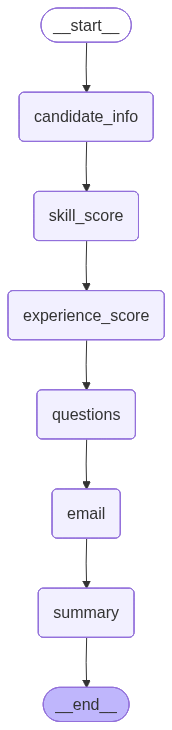

In [ ]:
# define workflow
workflow = graph.compile()
workflow

In [95]:
requirement = """Job Title: Backend Software Engineer
Experience Required: 3–5 years
Key Skills:
- Python (advanced)
- SQL and database design
- AWS cloud services (Lambda, S3, EC2)
- Docker & Git
- Bonus: Experience with FastAPI or Flask
Responsibilities:
- Develop and maintain backend services.
- Design scalable APIs.
- Deploy applications on AWS.
- Collaborate with product and frontend teams.
"""

resume = """Name: Priya Sharma
Email: priya.sharma@example.com
Experience: 4 years as a Software Engineer
Summary:
Software engineer with experience in backend development, cloud deployment, and API integration. Skilled in Python, SQL, and AWS services. Looking to contribute to scalable systems and innovative projects.
Work Experience:
- Software Engineer, TechNova Solutions (2021–2025)
- Built REST APIs in Python (FastAPI, Flask).
- Deployed microservices on AWS (EC2, Lambda, S3).
- Designed relational databases with PostgreSQL.
- Collaborated with cross-functional teams for agile delivery.
- Junior Developer, CodeWorks (2019–2021)
- Assisted in developing internal tools using Python.
- Wrote SQL queries for reporting and analytics.
- Supported migration of legacy systems to cloud.
Skills:
- Python, SQL, AWS (EC2, Lambda, S3)
- REST API development
- Git, Docker
- Agile methodology
Education:
B.Tech in Computer Science, Delhi University (2019)

"""

In [ ]:
# execute the workflow
response = workflow.invoke({'resume_text': resume, 'requirements': requirement})

In [ ]:
response

{'resume_text': 'Name: Priya Sharma\nEmail: priya.sharma@example.com\nExperience: 4 years as a Software Engineer\nSummary:\nSoftware engineer with experience in backend development, cloud deployment, and API integration. Skilled in Python, SQL, and AWS services. Looking to contribute to scalable systems and innovative projects.\nWork Experience:\n- Software Engineer, TechNova Solutions (2021–2025)\n- Built REST APIs in Python (FastAPI, Flask).\n- Deployed microservices on AWS (EC2, Lambda, S3).\n- Designed relational databases with PostgreSQL.\n- Collaborated with cross-functional teams for agile delivery.\n- Junior Developer, CodeWorks (2019–2021)\n- Assisted in developing internal tools using Python.\n- Wrote SQL queries for reporting and analytics.\n- Supported migration of legacy systems to cloud.\nSkills:\n- Python, SQL, AWS (EC2, Lambda, S3)\n- REST API development\n- Git, Docker\n- Agile methodology\nEducation:\nB.Tech in Computer Science, Delhi University (2019)\n\n',
 'require